In [1]:
%matplotlib inline

In [2]:
import os
import sys

In [3]:
print sys.version

2.7.14 (default, Feb 15 2018, 20:22:28) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
import xgboost as xgb
import pymatgen as mg
import datetime as dt

/usr/local/lib/python2.7/site-packages/pymatgen/__init__.py:87: UserWarning: 
Pymatgen will drop Py2k support from v2019.1.1. Pls consult the documentation
at https://www.pymatgen.org for more details.
  at https://www.pymatgen.org for more details.""")


In [6]:
from utils import rmsle

In [7]:
from dataload import load_features

### Load data

In [9]:
DATA_DIR = './data'

In [10]:
train, test = load_features(DATA_DIR, with_ext=False, with_geo=False)

### Build train and test data sets

In [12]:
X_train = train.drop(['id', 'natoms', 'spacegroup',
                      'alpha', 'beta', 'gamma',
                      'ga', 'cellvol',
                      'bandgap', 'E0'], axis=1)
X_test = test.drop(['id', 'natoms', 'spacegroup',
                    'alpha', 'beta', 'gamma',
                    'ga', 'cellvol'], axis=1)

In [13]:
# Use log1p of energies to correct for skew
y_bg_train = np.log1p(train['bandgap'])
y_e0_train = np.log1p(train['E0'])

In [14]:
X_train = pd.concat([X_train.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_train['spacegroup_natoms'])], axis=1)
X_test = pd.concat([X_test.drop('spacegroup_natoms', axis=1),
                    pd.get_dummies(X_test['spacegroup_natoms'])], axis=1)

In [15]:
X_train.head()

,al,in,a,b,c,atom_density,alpha_r,beta_r,gamma_r,12_20,12_80,167_30,167_60,194_10,194_80,206_80,227_40,33_40,33_80
0,0.6250,0.000,9.9523,8.5513,9.1775,0.102426,1.570842,1.570836,1.570826,0,0,0,0,0,0,0,0,0,1
1,0.6250,0.000,6.1840,6.1838,23.6287,0.102236,1.571121,1.570761,2.094439,0,0,0,0,0,1,0,0,0,0
2,0.8125,0.000,9.7510,5.6595,13.9630,0.102242,1.587705,1.590393,0.532648,0,0,0,0,0,0,0,1,0,0
3,0.7500,0.250,5.0036,5.0034,13.5318,0.102257,1.570601,1.571004,2.094425,0,0,1,0,0,0,0,0,0,0
4,0.0000,0.375,6.6614,6.6612,24.5813,0.084682,1.570727,1.570807,2.094208,0,0,0,0,0,1,0,0,0,0


In [16]:
# Create DMatrix for train and test
dtrain_bg = xgb.DMatrix(data=X_train, label=y_bg_train)
dtrain_e0 = xgb.DMatrix(data=X_train, label=y_e0_train)
dtest = xgb.DMatrix(data=X_test)

### Build the XGBoost models and train

In [17]:
param = {'eta': 0.05,                 # Step size shrinkage used in update (Learning rate)
         'alpha': 0.10,               # L1 regularization term on weights
         'max_depth': 5,
         'silent': True,
         'objective': 'reg:linear'}
num_round = 1000

In [18]:
result_e0 = xgb.cv(param, dtrain_e0, num_round, nfold=5,
                   metrics={'rmse'}, seed=42,
                   callbacks=[xgb.callback.print_evaluation(show_stdv=True)],
                   early_stopping_rounds=4)

[0]	train-rmse:0.326203+0.00108975	test-rmse:0.326216+0.00444432
[1]	train-rmse:0.310323+0.0010299	test-rmse:0.310367+0.00421252
[2]	train-rmse:0.295245+0.000967873	test-rmse:0.295321+0.00403452
[3]	train-rmse:0.280931+0.000915862	test-rmse:0.281044+0.00380521
[4]	train-rmse:0.26734+0.00086557	test-rmse:0.267526+0.00362725
[5]	train-rmse:0.254435+0.00082174	test-rmse:0.254658+0.00344647
[6]	train-rmse:0.242177+0.000772122	test-rmse:0.242482+0.00327838
[7]	train-rmse:0.230538+0.000722792	test-rmse:0.230888+0.00313875
[8]	train-rmse:0.219493+0.000686081	test-rmse:0.219895+0.00300223
[9]	train-rmse:0.20901+0.000637658	test-rmse:0.209479+0.00287885
[10]	train-rmse:0.199049+0.000599317	test-rmse:0.199553+0.00273866
[11]	train-rmse:0.189587+0.000560097	test-rmse:0.190123+0.00257433
[12]	train-rmse:0.180603+0.0005225	test-rmse:0.181205+0.00249061
[13]	train-rmse:0.172064+0.000495226	test-rmse:0.172708+0.00236717
[14]	train-rmse:0.163963+0.00047804	test-rmse:0.164616+0.00222514
[15]	train-rmse

[121]	train-rmse:0.0258828+0.000613095	test-rmse:0.0331578+0.0026253
[122]	train-rmse:0.025844+0.000613155	test-rmse:0.0331646+0.00262233
[123]	train-rmse:0.0258122+0.000604636	test-rmse:0.0331582+0.00262749


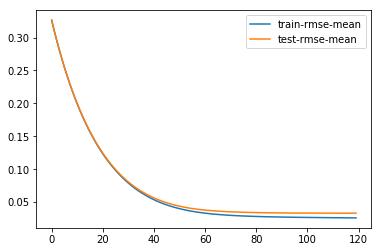

In [19]:
result_e0[['train-rmse-mean', 'test-rmse-mean']].plot();

In [20]:
model_e0 = xgb.train(param, dtrain_e0, len(result_e0))

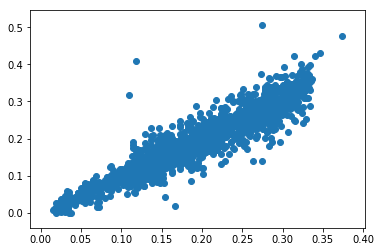

In [21]:
plt.scatter(model_e0.predict(dtrain_e0), y_e0_train);

In [22]:
result_bg = xgb.cv(param, dtrain_bg, num_round, nfold=5,
                   metrics={'rmse'}, seed=42,
                   callbacks=[xgb.callback.print_evaluation(show_stdv=True)],
                   early_stopping_rounds=4)

[0]	train-rmse:0.627176+0.00380922	test-rmse:0.627179+0.0151665
[1]	train-rmse:0.596884+0.00361874	test-rmse:0.597057+0.0142805
[2]	train-rmse:0.56812+0.00343786	test-rmse:0.568428+0.0135854
[3]	train-rmse:0.540817+0.00326277	test-rmse:0.54126+0.0127902
[4]	train-rmse:0.514895+0.00309088	test-rmse:0.515518+0.0120927
[5]	train-rmse:0.490278+0.00293562	test-rmse:0.491011+0.0114406
[6]	train-rmse:0.466929+0.00279694	test-rmse:0.467916+0.0107958
[7]	train-rmse:0.44475+0.00265136	test-rmse:0.445906+0.0101186
[8]	train-rmse:0.423689+0.00252973	test-rmse:0.425057+0.0095874
[9]	train-rmse:0.403694+0.00240633	test-rmse:0.405267+0.00905292
[10]	train-rmse:0.38473+0.00228871	test-rmse:0.386508+0.00858666
[11]	train-rmse:0.366744+0.00218557	test-rmse:0.368878+0.00818912
[12]	train-rmse:0.349679+0.00207518	test-rmse:0.351997+0.00769877
[13]	train-rmse:0.333481+0.00196993	test-rmse:0.336003+0.00725812
[14]	train-rmse:0.318121+0.00190449	test-rmse:0.320983+0.00694962
[15]	train-rmse:0.303559+0.001823

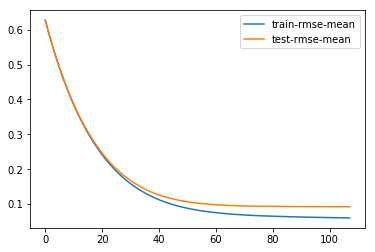

In [23]:
result_bg[['train-rmse-mean', 'test-rmse-mean']].plot();

In [24]:
model_bg = xgb.train(param, dtrain_bg, len(result_bg))

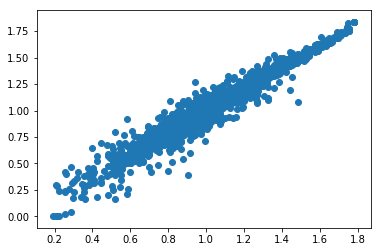

In [25]:
plt.scatter(model_bg.predict(dtrain_bg), y_bg_train);

### Output predictions

In [26]:
predicted_bg = np.expm1(model_bg.predict(dtest))
predicted_e0 = np.expm1(model_e0.predict(dtest))

In [27]:
predicted = pd.DataFrame({'formation_energy_ev_natom': predicted_e0,
                          'bandgap_energy_ev': predicted_bg}) \
              .reset_index().rename(columns={'index': 'id'})
predicted['id'] += 1

In [28]:
predicted.head()

,id,bandgap_energy_ev,formation_energy_ev_natom
0,1,1.628758,0.204649
1,2,3.640649,0.064997
2,3,3.380768,0.159487
3,4,2.994715,0.030672
4,5,1.625701,0.139827


In [29]:
err_e0 = rmsle(np.expm1(model_e0.predict(dtrain_e0)), np.expm1(y_e0_train))
err_bg = rmsle(np.expm1(model_bg.predict(dtrain_bg)), np.expm1(y_bg_train))

In [30]:
# Training RMSLE values
print "RMSLE BG: {}, RMSLE E0: {}, RMSLE AVG: {}".format(err_bg, err_e0,
                                                         0.5 * (err_bg + err_e0))

RMSLE BG: 0.0636890090164, RMSLE E0: 0.026646498519, RMSLE AVG: 0.0451677537677


#### Write to file:

In [199]:
now = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
predicted.to_csv(os.path.join('output', 'xgb-{}.csv'.format(now)),
                columns=['id', 'formation_energy_ev_natom', 'bandgap_energy_ev'],
                index=False)